In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
import math
from torch.utils.data import Dataset

In [5]:
# config
embeddingSize=768
numPoints=30
numVars=1
numYs=1
paddingToken='<PAD>'
padId=0
extractAttributes = False
block_size = 500 # spatial extent of the model for its context

In [40]:
class CharDataset(Dataset):

    def __init__(self, data, block_size, extractAtt=False, chars=None, stoi=None, itos=None, testTime=False):
        self.chars = sorted(list(set(data))+['T']) if chars==None else chars
        data_size, vocab_size = len(data), len(self.chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate([paddingToken]+self.chars if extractAtt else self.chars) } if stoi==None else stoi
        self.itos = { i:ch for i,ch in enumerate([paddingToken]+self.chars if extractAtt else self.chars) } if itos==None else itos
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
        self.attributes = extractAtt
        self.threshold = [-1000,1000]
        self.testTime = testTime
        
        if self.attributes or self.testTime:
            self.dataList = self.data.split('\n') #TODO: remove later?

            self.blockIdx = []
            summation = 0
            for d in self.dataList:
                s = summation
                e = s + len(d)
                self.blockIdx.append((s,e))
                summation = e+1
    
    def __len__(self):
        if self.attributes or self.testTime:
            return len(self.dataList) - 1
        else:
            return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        #chunk = self.data[idx:idx + self.block_size + 1]
        if not self.attributes:
            if self.testTime:
                chunk = self.data[self.blockIdx[idx][0]:self.blockIdx[idx][1]]
            else:
                chunk = self.data[idx:idx + self.block_size + 1]
                
            dix = [self.stoi[s] for i,s in enumerate(chunk)]
            inputs = torch.tensor(dix[:-1], dtype=torch.long).contiguous()
            outputs = torch.tensor(dix[1:], dtype=torch.long).contiguous()
            return inputs, outputs
        else:
            chunk = self.data[self.blockIdx[idx][0]:self.blockIdx[idx][1]]
        
            # extracts other attributes
            points = None
            if self.attributes:
                dic = json.loads(chunk)
                points = []
                for xy in zip(dic['X'], dic['Y']):
                    x = xy[0] + [self.stoi[paddingToken]]*(max(numVars-len(xy[0]),0)) # padding
                    y = [xy[1]] if type(xy[1])== float else xy[1]
                    y = y + [self.stoi[paddingToken]]*(max(numYs-len(y),0)) # padding

                    p = x + y #x.extend(y)
                    p = torch.tensor(p)

                    #replace nan and inf
                    p = torch.nan_to_num(p, nan=0.0, 
                                         posinf=self.threshold[1], 
                                         neginf=self.threshold[0])

                    points.append(p)
                chunk = '"'+dic['EQ']+'"'

            # encode every character to an integer
            dix = [self.stoi[s] for i,s in enumerate(chunk) if i<self.block_size]
            paddingSize = max(self.block_size-len(dix),0)

            mask = [1] + [1 for s in dix]
            #dixX = dix + [self.stoi[paddingToken]]*paddingSize # padding
            dix += [self.stoi[paddingToken]]*paddingSize # padding
            mask += [0]*paddingSize

            inputs = torch.tensor(dix[:-1], dtype=torch.long).contiguous()
            mask = torch.tensor(mask[:-1], dtype=torch.long).contiguous()
            mask = mask.unsqueeze(0)
            mask = mask.T @ mask

            """
            arrange data and targets so that the first i elements of x
            will be asked to predict the i-th element of y. Notice that
            the eventual language model will actually make block_size
            individual predictions at the same time based on this data,
            so we are being clever and amortizing the cost of the forward
            pass of the network. So for example if block_size is 4, then
            we could e.g. sample a chunk of text "hello", the integers in
            x will correspond to "hell" and in y will be "ello". This will
            then actually "multitask" 4 separate examples at the same time
            in the language model:
            - given just "h", please predict "e" as next
            - given "he" please predict "l" next
            - given "hel" predict "l" next
            - given "hell" predict "o" next

            In addition, because the DataLoader will create batches of examples,
            every forward/backward pass during traning will simultaneously train
            a LOT of predictions, amortizing a lot of computation. In particular,
            for a batched input of integers X (B, T) where B is batch size and
            T is block_size and Y (B, T), the network will during training be
            simultaneously training to make B*T predictions, all at once! Of course,
            at test time we can paralellize across batch B, but unlike during training
            we cannot parallelize across the time dimension T - we have to run
            a forward pass of the network to recover the next single character of the 
            sequence along each batch dimension, and repeatedly always feed in a next
            character to get the next one.

            So yes there is a big asymmetry between train/test time of autoregressive
            models. During training we can go B*T at a time with every forward pass,
            but during test time we can only go B at a time, T times, with T forward 
            passes.
            """        

            outputs = torch.tensor(dix[1:], dtype=torch.long).contiguous()

            #assert mask.shape==outputs.shape==inputs.shape, 'M:{}-O:{}-I:{}'.format(mask.shape,outputs.shape,inputs.shape)
            assert len(mask) == self.block_size, 'Wrong mask shape: {}'.format(mask.shape)
            assert len(inputs) == self.block_size-1, 'Wrong inputs shape: {}'.format(inputs.shape)
            assert len(outputs) == self.block_size-1, 'Wrong y shape: {}'.format(outputs.shape)
            assert len(points) == numPoints, 'Wrong #points: {}'.format(len(points))

            return inputs, outputs, points, mask

In [7]:
import json
from tqdm import tqdm
import glob
def processDataFiles(files):
    text = ''""
    for f in tqdm(files):
        with open(f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            text += lines #json.loads(line)                
    return text

In [8]:
path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TrainDatasetFixed\*.json'
files = glob.glob(path)
text = processDataFiles(files[0:3]) #[files[0]])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]


In [9]:
# avgBlockSize = 0
# upNum = 100
# for i in tqdm(range(0,upNum)):
#     avgBlockSize += len(text.split('\n')[i])
# avgBlockSize /= upNum
# print('avg block size is {}'.format(avgBlockSize))

In [10]:
train_dataset = CharDataset(text, block_size, extractAtt=extractAttributes) 

data has 729216651 characters, 44 unique.


In [27]:
idx = np.random.randint(min(train_dataset.__len__(),1000))
sample = test_dataset.__getitem__(idx)
batch = sample
if extractAttributes:
    x,y,p,m = batch
    print('XS:{}\nMS:{}\nyS:{}\nPointsS:{}'.format(x.shape,m.shape,y.shape,len(p)))
    print('X:{}\nM:{}\ny:{}\nPoints:{}'.format(x,m,y,p))
else:
    x,y = batch
    print('X:{}\ny:{}\n'.format(x,y))
    xc = ''.join([train_dataset.itos[int(i)] for i in x]).strip('"')
    yc = ''.join([train_dataset.itos[int(i)] for i in y]).strip('"')
    print('x:{}\n\ny:{}'.format(xc,yc))

X:tensor([ 9, 12, 30,  7,  1, 29, 12,  9, 17, 17, 30,  7,  1, 29, 11,  9, 11, 30,
         7,  1, 29, 12,  9, 18, 17, 30,  7,  1, 29, 12,  9, 19, 17, 30,  7,  1,
        29, 12,  9, 20, 18, 30,  7,  1, 29, 13,  9, 11, 18, 30,  7,  1, 29, 13,
         9, 12, 18, 30,  7,  1, 29, 13,  9, 13, 19, 30,  7,  1, 29, 13,  9, 14,
        19, 30,  7,  1, 29, 13,  9, 15, 19, 30,  7,  1, 29, 13,  9, 16, 20, 30,
         7,  1, 29, 13,  9, 17, 20, 30,  7,  1, 29, 13,  9, 18, 20, 30,  7,  1,
        29, 13,  9, 20, 30,  7,  1, 29, 14,  9, 11, 30, 30,  7,  1,  2, 28,  2,
        21,  1, 29,  8, 12,  9, 11,  7,  1,  8, 12,  9, 11,  7,  1,  8, 11,  9,
        20, 20,  7,  1,  8, 11,  9, 20, 19,  7,  1,  8, 11,  9, 20, 18,  7,  1,
         8, 11,  9, 20, 16,  7,  1,  8, 11,  9, 20, 15,  7,  1,  8, 11,  9, 20,
        12,  7,  1,  8, 11,  9, 19, 20,  7,  1,  8, 11,  9, 19, 17,  7,  1,  8,
        11,  9, 19, 14,  7,  1,  8, 11,  9, 18, 20,  7,  1,  8, 11,  9, 18, 18,
         7,  1,  8, 11,  9, 18, 13,  7

In [41]:
path = 'D:\Datasets\Symbolic Dataset\Datasets\Mesh_Simple_GPT2_Sorted\TestDataset\*.json'
files = glob.glob(path)
textTest = processDataFiles([files[0]])
test_dataset = CharDataset(textTest, block_size, extractAtt=extractAttributes,
                           testTime=True,
                           chars=train_dataset.chars, stoi=train_dataset.stoi, 
                           itos=train_dataset.itos)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 331.28it/s]

data has 901208 characters, 44 unique.


In [13]:
torch.cuda.is_available()

True

In [14]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=numPoints, 
                       numberofVars=numVars, 
                       numberofYs=numYs)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size-1 if extractAttributes else train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize, grad_norm_clip=1.0,
                  padToken=paddingToken, padId=padId)
model = GPT(mconf)#, pconf)

05/14/2021 01:44:11 - INFO - mingpt.model -   number of parameters: 5.715610e+07


In [15]:
model

GPT(
  (tok_emb): Embedding(44, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=768, out_features=768, bias=True)
        (query): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU()
        (2): Linear(in_features=3072, out_features=768, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (

In [ ]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=150, batch_size=16, learning_rate=5e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*block_size,
                      num_workers=0)
trainer = Trainer(model, train_dataset, test_dataset, tconf)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

epoch 1 iter 33992: train loss 0.11873. lr 4.999998e-04:   0%|         | 33993/45576010 [4:00:53<5677:48:10,  2.23it/s]

In [42]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [43]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
#from gp_model import Genetic_Model
#from mlp_model import MLP_Model
    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

# gpm = Genetic_Model(n_jobs=-1)
# mlp = MLP_Model()
    
fName = 'res.txt'
resultDict = {}
with open(fName, 'w', encoding="utf-8") as o:
    textTestList = textTest.split('\n')
    modelName = 'SymbolicGPT'
    resultDict[fName] = {modelName:[]}
    
    for i, batch in enumerate(loader):
        if extractAttributes:
            x,y,m,p = batch
        else:
            x,y = batch
        
        print('Test Case {}.'.format(i))
        o.write('Test Case {}/{}.'.format(i,len(textTestList)))
        
        t = json.loads(textTestList[i])
        
        if model.pointNetConfig:
            x = x[:,0:1].to(trainer.device)
            p = [e.to(trainer.device) for e in p]
            yHat = sample(model, x, 50, points=p, 
                          temperature=1.0, sample=True, 
                          top_k=10)[0]
        else:
            sos_eq_loc = loc = (x == test_dataset.stoi['E']).nonzero(as_tuple=True) 
            # pass everything (x,y) to the model except the equations
            x = x[:,:loc[1].item()+5].to(trainer.device)
            #x = x[:,0:sos_eq_loc].to(trainer.device)
            yHat = sample(model, x, block_size, points=None, 
                          temperature=1.0, sample=True, 
                          top_k=10)[0]
            
        # filter out predicted
        target = ''.join([train_dataset.itos[int(i)] for i in y[0]])
        predicted = ''.join([train_dataset.itos[int(i)] for i in yHat])

        if extractAttributes:
            target = target.strip('"')
            target = target.strip(paddingToken)
            predicted = predicted.strip(paddingToken)
        else:
            target = target[loc[1].item()+5:].split('"')[0]
            predicted = predicted[loc[1].item()+5+1:].split('"')[0]

        o.write('{}'.format(target))
        
        print('Target:{}\nPredicted:{}'.format(target, predicted))
        
        Ys = [] #t['YT']
        Yhats = []
        for xs in t['XT']:
            try:
                eqTmp = target + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                YEval = eval(eqTmp)
                YEval = 0 if np.isnan(YEval) else YEval
                YEval = 10000 if np.isinf(YEval) else YEval
            except:
                YEval = 10000 #TODO: Maybe I have to punish the model for each wrong template
            Ys.append(YEval)
            try:
                eqTmp = predicted + '' # copy eq
                eqTmp = eqTmp.replace(' ','')
                eqTmp = eqTmp.replace('\n','')
                for i,x in enumerate(xs):
                    # replace xi with the value in the eq
                    eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                    if ',' in eqTmp:
                        assert 'There is a , in the equation!'
                Yhat = eval(eqTmp)
                Yhat = 0 if np.isnan(Yhat) else Yhat
                Yhat = 10000 if np.isinf(Yhat) else Yhat
            except:
                Yhat = 10000
            Yhats.append(Yhat)
        mseErr = mse(Ys,Yhats)
        
        if type(mseErr) is np.complex128:
            mseErr = mseErr.real
        elif mseErr < 0.00005:
            mseErr = 0
            
        resultDict[fName][modelName].append(mseErr)
        
        o.write('{}:{}\n{}'.format(modelName, 
                               mseErr,
                               predicted))
        
        print('MSE:{}\n'.format(mseErr))

Test Case 0.
Target:-sin(1.1*x1+0.64)
Predicted:-sin(1.01*x1+0.93)
MSE:0.014782068622960134

Test Case 1.
Target:-1.42*x1+sqrt(x1+0.53)
Predicted:0.73-0.9*x1
MSE:0.7892273970739022

Test Case 2.
Target:sqrt(-sin(0.2*x1))
Predicted:0.44*sqrt(x1)
MSE:0.0038600454437391343

Test Case 3.
Target:sin(sqrt(x1))
Predicted:sin(sqrt(x1))
MSE:0

Test Case 4.
Target:0.86*x1**2-0.59*x1+1.36
Predicted:x1**2-0.21*x1+0.88*sqrt(-0.71*x1-1)+0.0
MSE:29.258644534634875

Test Case 5.
Target:0.28*sqrt(-x1**2)
Predicted:0.28*sqrt(-x1**2)
MSE:0

Test Case 6.
Target:sin(0.07*x1**2+0.28*x1)
Predicted:sin(0.4*x1)
MSE:0.7109081367653577

Test Case 7.
Target:sin(x1)
Predicted:sin(x1)
MSE:0

Test Case 8.
Target:0.81*sqrt(-x1**2-0.95*x1+0.12)
Predicted:0.82*sqrt(-x1**2-0.27*x1+0.1)
MSE:0.04431808744545489

Test Case 9.
Target:sin(x1+0.37)
Predicted:sin(x1+0.37)
MSE:0

Test Case 10.
Target:-0.68*x1**2+1.77*x1
Predicted:-0.21*x1**2
MSE:8.923364263666675

Test Case 11.
Target:sqrt(x1)+0.51*x1**2-0.17*x1
Predicted:0.43*

Target:sin(0.34*x1)
Predicted:sin(0.32*x1)
MSE:0.0006062950428839585

Test Case 92.
Target:0.83*sqrt(-x1)
Predicted:0.82*sqrt(-x1)
MSE:0.00045500000000000076

Test Case 93.
Target:sin(x1)+sin(x1-0.38)
Predicted:sin(x1-0.28)+sin(x1-0.28)
MSE:0.015826420174581454

Test Case 94.
Target:0.94*sqrt(-0.65*x1-1)
Predicted:0.94*sqrt(-0.62*x1-1)
MSE:0.0010609761264266026

Test Case 95.
Target:-2*x1*sin(0.58*x1)+1.0
Predicted:-1.58*x1*sin(0.42*x1+0.55)
MSE:6.657783876819242

Test Case 96.
Target:sin(sqrt(x1+0.02))
Predicted:sin(sqrt(x1+0.02))
MSE:0

Test Case 97.
Target:x1**(1/4)
Predicted:x1**(1/4)
MSE:0

Test Case 98.
Target:0
Predicted:0
MSE:0

Test Case 99.
Target:2*x1*sin(0.88*x1)+0.35
Predicted:2*x1*sin(x1)+0.36
MSE:9.735429248878798

Test Case 100.
Target:sqrt(x1+0.22)
Predicted:0.06*x1**2+0.08*x1+0.47*sqrt(x1+0.36)
MSE:0.4546349762617748

Test Case 101.
Target:sin(x1)
Predicted:sin(x1)
MSE:0

Test Case 102.
Target:sqrt(x1)+sin(x1+0.65)
Predicted:sqrt(x1)+sin(x1+0.65)
MSE:0

Test Case 103.

Target:0.77*sqrt(0.35*x1+1)+sin(x1-0.89)
Predicted:0.81*x1*sin(0.52*x1)+0.02
MSE:1.843854682415648

Test Case 183.
Target:0.29*x1**2-0.24*x1
Predicted:2*x1-0.17*sin(0.21*x1)
MSE:14.871835031125585

Test Case 184.
Target:sin(0.41*x1+0.67)
Predicted:sin(0.35*x1+0.68)
MSE:0.04612428183421482

Test Case 185.
Target:0.08*x1**2-0.53
Predicted:0.03*x1**2-0.14*x1
MSE:1.6577593250000002

Test Case 186.
Target:2*x1-0.44
Predicted:2*x1-0.44
MSE:0

Test Case 187.
Target:0.72*x1**2-0.06*x1-sin(0.71*x1)
Predicted:0.36*x1**2*sqrt(x1+0.54)-0.7*x1
MSE:1.7822366625179238

Test Case 188.
Target:-0.81*x1
Predicted:-0.8*x1
MSE:0.002145166666666677

Test Case 189.
Target:0.33*sqrt(-x1**2)
Predicted:0.34*sqrt(-x1**2)
MSE:0.0021451666666666676

Test Case 190.
Target:-0.34*x1**3+0.02*x1
Predicted:1.1*x1
MSE:2027.7420964604669

Test Case 191.
Target:sqrt(sin(x1))
Predicted:sqrt(sin(x1))
MSE:0

Test Case 192.
Target:sin(0.95*sqrt(-x1))
Predicted:sin(0.93*sqrt(x1))
MSE:0.0004008477793934096

Test Case 193.
Target

Target:x1-sin(0.8*x1)
Predicted:x1+0.07*sin(0.38*x1)
MSE:0.3822934889558163

Test Case 276.
Target:0.06*x1**(5/2)+0.06*x1-0.05
Predicted:0.25*x1**2*sin(0.15*x1+0.58)-0.07*x1
MSE:3.6064387707986314

Test Case 277.
Target:sin(x1)
Predicted:sin(x1)
MSE:0

Test Case 278.
Target:-0.45*x1-0.27
Predicted:-0.44*x1+sin(0.08*x1-0.17)
MSE:0.263737562710239

Test Case 279.
Target:sin(x1)
Predicted:sin(x1)
MSE:0

Test Case 280.
Target:0.87*(-x1)**(1/4)
Predicted:0.88*x1**(1/4)
MSE:-0.6546351130713903

Test Case 281.
Target:sin(sin(x1+0.92))
Predicted:sin(sin(x1+0.92))
MSE:0

Test Case 282.
Target:0.91*x1**(1/4)
Predicted:0.91*(-x1)**(1/4)
MSE:-0.7282860932258217

Test Case 283.
Target:0.73*sqrt(-x1)
Predicted:0.74*sqrt(x1)
MSE:0.00045500000000000125

Test Case 284.
Target:0.75*sqrt(0.09*x1+1)
Predicted:sin(0.06*x1+0.82)
MSE:0

Test Case 285.
Target:-0.04*x1**2*sqrt(x1-0.54)-0.01*x1
Predicted:-sin(0.02*x1**2+0.01*x1)
MSE:2.3532571210086974

Test Case 286.
Target:-0.13*x1**2+0.32*x1+sin(0.05*x1)+0.48

Target:x1**(1/4)
Predicted:x1**(1/4)
MSE:0

Test Case 372.
Target:-sin(sin(0.11*x1+0.98))
Predicted:-0.66*x1+0.74*sin(0.09*x1-0.77)
MSE:6.1506339932407705

Test Case 373.
Target:-0.41*x1*sin(0.5*x1)
Predicted:-0.21*x1+0.12*sin(0.42*x1)
MSE:0.3772278789085874

Test Case 374.
Target:-0.99*x1-0.52*sin(0.25*x1)
Predicted:0.24*x1**2-0.23*x1
MSE:88.97270259311763

Test Case 375.
Target:1.0*x1**(3/2)-0.53
Predicted:0.82*x1*sqrt(-0.97*x1-1)-0.29
MSE:0.8601100497208353

Test Case 376.
Target:-0.76*x1**2-1.2*x1-0.73
Predicted:-0.92*x1**2-0.72*x1-0.73
MSE:2.283263914666667

Test Case 377.
Target:-0.45*x1**2+2.14*x1+0.77
Predicted:0.92*x1+sin(x1-0.07)+0.78
MSE:17.770111803557235

Test Case 378.
Target:sin(x1**2+0.43*x1-0.12)
Predicted:sin(x1**2+0.14*x1-0.11)
MSE:0.757761089873474

Test Case 379.
Target:-sin(0.12*x1**2+0.63*x1-0.55)
Predicted:-sin(0.88*x1-0.66)
MSE:0.9178387809833897

Test Case 380.
Target:-sin(sin(0.61*x1+0.59))
Predicted:-sin(sin(0.65*x1+0.69))
MSE:0.04075890269813693

Test Case 

Target:0.95*x1+sin(x1)-0.22
Predicted:x1+sin(0.68*x1-0.22)+0.23
MSE:2.646822371389139

Test Case 464.
Target:x1-0.41*sin(0.11*x1+0.63)
Predicted:0.95*x1
MSE:0.02079821331369003

Test Case 465.
Target:0.56*x1*sin(x1+0.17)+0.68
Predicted:x1*sin(x1+0.45)+0.82
MSE:1.7684187822967354

Test Case 466.
Target:-sqrt(x1-0.06)*sin(0.35*x1)
Predicted:-0.3*x1*sqrt(-0.22*x1-1)
MSE:0.0960279034564418

Test Case 467.
Target:-0.05*x1+0.99*sqrt(0.19*x1-1)-0.71
Predicted:0.28*sqrt(-0.56*x1**2+x1)
MSE:1.8185400029550765

Test Case 468.
Target:-0.47*x1**2+0.48*x1
Predicted:-0.08*x1**2+0.64*x1
MSE:93.07767615966665

Test Case 469.
Target:x1**2-0.29*x1+sin(x1+0.52)+0.01
Predicted:0.68*x1**2+0.31*x1+0.51
MSE:14.323348142465091

Test Case 470.
Target:0.21*x1*sqrt(x1-0.95)+0.87
Predicted:0.84*sqrt(0.44*x1-1)*sqrt(x1+0.69)
MSE:0.641813465572668

Test Case 471.
Target:-0.75*x1-0.18
Predicted:-0.57*x1**2-0.28*x1+0.03
MSE:114.40807158366664

Test Case 472.
Target:sqrt(x1)
Predicted:sqrt(x1)
MSE:0

Test Case 473.
Ta

Target:2*sqrt(x1)
Predicted:2*sqrt(x1)
MSE:0

Test Case 553.
Target:-sin(0.65*x1)
Predicted:-sin(0.71*x1)
MSE:0.05550744306197259

Test Case 554.
Target:x1**2-0.82*x1+0.16
Predicted:x1**2-0.99*x1+0.22
MSE:0.5307331666666674

Test Case 555.
Target:sin(sin(x1-0.2))
Predicted:sin(sin(x1-0.21))
MSE:0

Test Case 556.
Target:sqrt(x1)
Predicted:sqrt(x1)
MSE:0

Test Case 557.
Target:0.16*x1**2+1.51*x1+0.45
Predicted:1.22*x1*sqrt(-x1-0.42)+0.38
MSE:5.403493211373637

Test Case 558.
Target:2*x1+0.75
Predicted:2*x1+0.75
MSE:0

Test Case 559.
Target:0.72*sqrt(x1)
Predicted:0.71*sqrt(x1)
MSE:0.0004550000000000012

Test Case 560.
Target:sin(sqrt(x1-0.36))
Predicted:sin(sqrt(x1-0.47))
MSE:0.00014205676604435194

Test Case 561.
Target:2*x1*sin(x1)-1.03
Predicted:0.94*x1*sin(x1-0.94)
MSE:35.51450536426231

Test Case 562.
Target:0.78*sqrt(0.21*x1**2-x1-0.84)
Predicted:-0.06*x1**2+0.7*x1+0.71
MSE:3.6376241093714166

Test Case 563.
Target:sin(sqrt(x1-0.29))
Predicted:sin(sqrt(x1-0.19))
MSE:0.0001307207741

Target:x1
Predicted:x1
MSE:0

Test Case 641.
Target:0.48*sqrt(-x1-0.78)
Predicted:sin(0.29*x1+0.44)
MSE:0.04263368907036603

Test Case 642.
Target:x1+0.78*sqrt(-0.99*x1-1)
Predicted:0.7*x1+0.78*sqrt(-x1-0.68)+0.06
MSE:1.892051517290867

Test Case 643.
Target:sin(1.75*x1-0.12)
Predicted:sin(1.67*x1)
MSE:0.038838248814969355

Test Case 644.
Target:-sin(1.0*x1+0.86)
Predicted:-sin(0.98*x1+0.97)
MSE:0.00014324570550659533

Test Case 645.
Target:0.68*sqrt(x1)
Predicted:0.66*sqrt(x1)
MSE:0.0018200000000000017

Test Case 646.
Target:0.83*sqrt(0.26-x1)+sin(0.24*x1+0.12)
Predicted:sqrt(x1-0.35)+sin(0.16*x1)
MSE:0.00988111652270136

Test Case 647.
Target:(x1-0.37)**(1/4)
Predicted:0.97*(x1-0.35)**(1/4)
MSE:0.0016884462618994146

Test Case 648.
Target:1.06*x1+0.09
Predicted:0.02*x1**2+sqrt(x1+0.09)
MSE:5.7838104932239505

Test Case 649.
Target:0.95*(-x1)**(1/4)
Predicted:0.94*x1**(1/4)
MSE:-0.8053217244149998

Test Case 650.
Target:0.7*x1*sqrt(0.52-x1)
Predicted:1.12*x1*sin(0.42*x1)+0.51
MSE:5.60

Target:-sin(0.29*x1)
Predicted:-sin(0.29*x1)
MSE:0

Test Case 729.
Target:1.02*x1
Predicted:1.0*x1
MSE:0.008580666666666681

Test Case 730.
Target:0.84*sqrt(0.53-x1)
Predicted:0.83*sqrt(x1-0.61)
MSE:0.0013608016442242547

Test Case 731.
Target:sqrt(sin(x1+0.22))
Predicted:sqrt(sin(x1+0.21))
MSE:0

Test Case 732.
Target:x1
Predicted:x1
MSE:0

Test Case 733.
Target:0.26*sqrt(-x1-0.96)*sqrt(-0.95*x1-1)
Predicted:0.29*sqrt(x1)*sqrt(x1+0.11)
MSE:0.00628306157184227

Test Case 734.
Target:0.5*x1+0.36
Predicted:0.46*x1+0.36
MSE:0.03432266666666658

Test Case 735.
Target:0.56*sqrt(0.86-x1)
Predicted:sqrt(sin(0.37*x1-0.5))
MSE:0.022027182271761793

Test Case 736.
Target:1.4*x1*sqrt(-x1)+0.78
Predicted:0.75*sqrt(x1)+1.55*x1
MSE:40.55698724225847

Test Case 737.
Target:0.94*x1
Predicted:0.91*sqrt(-x1**2)
MSE:0.0193064999999999

Test Case 738.
Target:sqrt(x1+0.35)-sin(0.04*x1+0.64)
Predicted:-0.09*x1**2+0.88*x1
MSE:0.37805072721177635

Test Case 739.
Target:0.19*x1**3-0.77*x1**2-0.43*x1
Predicted:

Target:0.84*sqrt(0.09*x1-1)
Predicted:0.84*sqrt(0.07*x1-1)
MSE:0.0025115267628440514

Test Case 822.
Target:sin(x1-0.76)
Predicted:sin(x1-0.76)
MSE:0

Test Case 823.
Target:0.68
Predicted:-0.04*x1*sqrt(0.04*x1+1)+0.84
MSE:0.0031176367878470055

Test Case 824.
Target:0.96*sqrt(-x1)
Predicted:0.95*sqrt(x1)
MSE:0.0004550000000000008

Test Case 825.
Target:1.31*x1-0.8
Predicted:1.29*x1-0.8
MSE:0.008580666666666676

Test Case 826.
Target:-sin(0.93*x1**2)
Predicted:-sin(0.6*x1**2+0.02*x1)
MSE:1.016435276039316

Test Case 827.
Target:sqrt(x1**2+0.81*x1)
Predicted:0.99*sqrt(x1**2+0.74*x1)
MSE:0.006698227069128881

Test Case 828.
Target:0.38*x1+sin(0.35*x1)
Predicted:0.59*x1
MSE:0.03701852304898275

Test Case 829.
Target:sin(0.37*x1)
Predicted:sin(0.39*x1)
MSE:0.0013432519372585452

Test Case 830.
Target:sqrt(x1+0.05)
Predicted:sqrt(x1+0.06)
MSE:0

Test Case 831.
Target:sqrt(sin(x1))
Predicted:sqrt(sin(x1))
MSE:0

Test Case 832.
Target:sqrt(x1+0.8)
Predicted:sqrt(x1+0.89)
MSE:0.0003854894577347

Target:0.87*x1+0.72
Predicted:0.86*x1+0.72
MSE:0.0021451666666666707

Test Case 913.
Target:sqrt(x1)
Predicted:sqrt(x1)
MSE:0

Test Case 914.
Target:sin(2*x1-0.59)
Predicted:sin(2*x1-0.62)
MSE:0.00045597331849297595

Test Case 915.
Target:x1+sin(x1+0.23)
Predicted:x1+sin(x1-0.25)
MSE:0.10799379977918844

Test Case 916.
Target:-0.07*x1**(3/2)-0.95
Predicted:-0.56*x1
MSE:0.9119037325407323

Test Case 917.
Target:sin(x1)
Predicted:sin(x1)
MSE:0

Test Case 918.
Target:0.91*sqrt(0.91*x1**2+x1+0.04)
Predicted:0.89*x1+0.19
MSE:0.027307821089471277

Test Case 919.
Target:0.38*x1**2+0.29*x1
Predicted:0.31*x1**2+0.18*x1
MSE:4.4287056503333355

Test Case 920.
Target:0.93*sqrt(x1-0.11)
Predicted:0.98*sqrt(-x1-0.1)
MSE:0.02368704181311669

Test Case 921.
Target:sqrt(x1)
Predicted:sqrt(x1)
MSE:0

Test Case 922.
Target:0.74*sqrt(-x1)
Predicted:0.75*sqrt(-x1)
MSE:0.00045500000000000103

Test Case 923.
Target:-sin(0.24*x1-0.14)
Predicted:0.14-0.25*x1
MSE:0.0498911191005555

Test Case 924.
Target:0.95*x

In [60]:
# # load the GP and MLP if it's available
# expPath = 'C:/Users/vpcom/OneDrive - University of Waterloo/Projects/symbolicgpt2/Experiments/OLD/'
# expFile = 'test_1var_simple_mesh_GPT2_XYSorted_1024_88000.out'

# with open(expPath+expFile, 'r') as f:
#     resultDict[fName]['GP'] = []
#     lines = f.readlines()
#     for line in lines:
#         filt = 'GP: '
#         if filt in line:
#             # save the error
#             err = float(line.split(filt)[1].strip('\n'))
#             resultDict[fName]['GP'].append(err)

C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


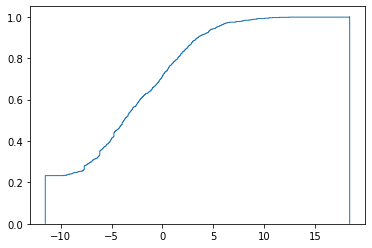

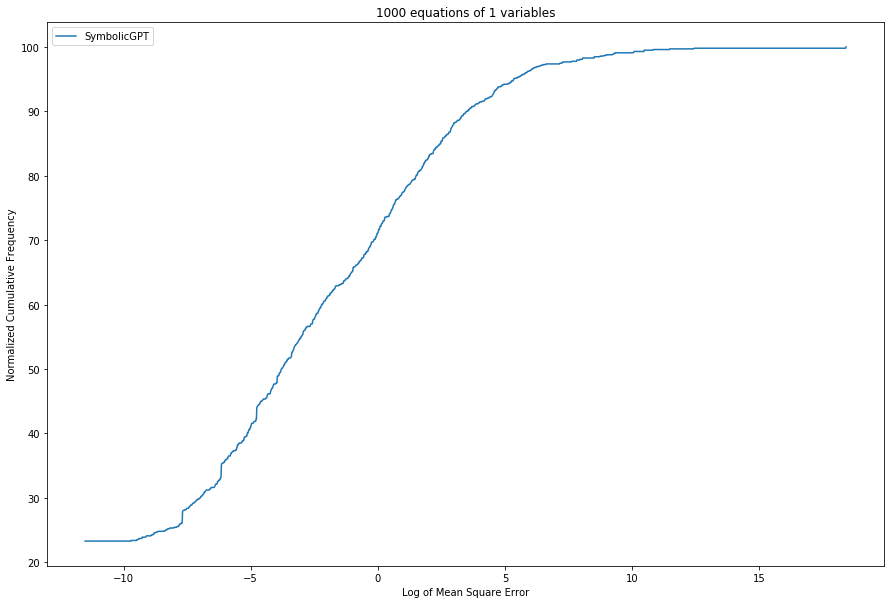

In [64]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(resultDict[fName].keys())
lists_of_error_scores = [resultDict[fName][key] for key in models]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([x+eps for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density="true")
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, m in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=m)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables".format(num_eqns, num_vars))
plt.xlabel("Log of Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format('results')
plt.savefig(name)